# PyPlot and MatplotLib Glitch Result Examples

This notebook can be used as a refernce for generating various graphs with your exported glitch results. Note that the one of the log parsers (`parse_results`) in use is specific to logs generated with this research. 

If you have exported your `GlitchController` object as a pickle, this can be parsed and loaded with the `parse_gc_pickle` function. Below are examples of each logfile being parsed into a GlitchResult class that was designed to help graph results

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import pickle

GLITCH_RESULTS = {
    0 : 'BOOT_MODE',
    1 : 'SWD_ENABLE',
    2 : 'FLASH_READ',
}

class GlitchResult:

    def __init__(self,x,y,z,offset,result):
        self.x = float(x)
        self.y = float(y)
        self.z = float(z)
        self.offset = int(offset)
        self.result = result

    def __str__(self):
        return f"X: {self.x} Y: {self.y} Z: {self.z} Offset: {self.offset} Result: {GLITCH_RESULTS[self.result]}"

def parse_results(result_path):
    glitches = []
    with open(result_path,'r') as infile:
        results = infile.readlines()
        print(f"Total Lines: {len(results)}")
        for line in results:
            if 'Boot' in line:
                result = 1 if "SWD" in line else 0
                vals = line.split(':')
                glitches.append(GlitchResult(vals[1].split('-')[0], 
                                             vals[2].split(" ")[1], 
                                             0, 
                                             vals[3].strip(),
                                             result))
    return glitches

def parse_gc_pickle(pickle_path):
    glitches = []
    inputFile = open(pickle_path,'rb')
    gcData = pickle.load(inputFile)
    gcDict = gcData.res_dict_of_lists(gcData._result_dict)
    for x in range(0,len(gcDict['normal'])):
        if gcDict['success'][x] == 1:
            if 'z' in gcDict:
                glitches.append(GlitchResult(gcDict['x'][x],gcDict['y'][x],gcDict['z'][x],['ext_offset'][x],0))
            else:
                glitches.append(GlitchResult(gcDict['x'][x],gcDict['y'][x],0,gcDict['ext_offset'][x],0))
    return glitches
    
def GenXYData(results):
    for x in range(0,len(foo['normal'])):
        if foo['success'][x] == 1:
            s_x.append(foo['x'][x])
            s_y.append(foo['y'][x])
        else:
            norm_x.append(foo['x'][x])
            norm_y.append(foo['y'][x])
    
'''
Basic class for doing data conversions, etc
Some things to consider,
We should be able to group them using various methods eg - by offset, x/y coordiate, etc
this might allow for some interesting data to fall out
'''
class GlitchGroup:
    def __init__(self,glitches):
        self.glitches = glitches
        self.ext_offsets = {}
        self.x = {}
        self.y = {}
        self.df = None
        self.extdf = None
        self.posdf = None
        self._gen_offset_stats()
        self._gen_dataframe()
        self._gen_positional_stats()

    def _gen_offset_stats(self):
        d = {"ext_offset":[], "count": []}
        for glitch in self.glitches:
            if glitch.offset not in self.ext_offsets:
                self.ext_offsets[glitch.offset] = 1
            else:
                self.ext_offsets[glitch.offset]+=1
        for element in self.ext_offsets:
            d["ext_offset"].append(element)
            d["count"].append(self.ext_offsets[element])
        self.extdf = pd.DataFrame(data=d)

    '''
    What do we want to generate here?
    For all X/Y combinations, generate a count for how many glitches occured
    '''
    def _gen_positional_stats(self):
        d = {"x":[],"y":[],"count":[]}
        self.posdf = self.df.groupby(["x","y"]).count().reset_index()
        print(self.posdf)


    def _gen_dataframe(self):
        d = {"ext_offset":[], "x":[], "y": []}
        for glitch in self.glitches:
            d["ext_offset"].append(glitch.offset)
            d["x"].append(glitch.x)
            d["y"].append(glitch.y)
        self.df = pd.DataFrame(data=d,dtype=np.float64)

    def _get_stats(self):
        test = sorted(self.ext_offsets, key=self.ext_offsets.get, reverse=True)


def GenerateGlitches(glitches):
    boot_glitches = []
    swd_glitches = []
    for glitch in glitches:
        swd_glitches.append(glitch) if glitch.result == 1 else boot_glitches.append(glitch)
    return boot_glitches,swd_glitches


'''
# Example 1: Parse glitch controller results 
gc_results = parse_gc_pickle('./logs/gc-pickle-stm32f4-184_185_86.5_87.5_NO_BOOT_MODE_.5_SLEEP.pickle')
gc_results_gg = GlitchGroup(gc_results)
'''

'''
# Example 2: Parse Custom logfile result
glitches = parse_results("logs/christmas-presents.log")
boot_glitches,swd_glitches = GenerateGlitches(glitches)
print(f"Boot Mode Glitches Total: {len(boot_glitches)}")
print(f"SWD Glitches Total: {len(swd_glitches)}")
gboot = GlitchGroup(boot_glitches)
sboot = GlitchGroup(swd_glitches)
'''

        x     y  ext_offset
0   184.0  86.6           5
1   184.0  86.7           5
2   184.0  86.8           3
3   184.0  86.9           8
4   184.0  87.0           4
..    ...   ...         ...
65  184.9  86.9           3
66  184.9  87.1           2
67  184.9  87.2           2
68  185.0  86.9           1
69  185.0  87.0           2

[70 rows x 3 columns]


'\n# Example 2: Parse Custom logfile result\nglitches = parse_results("logs/christmas-presents.log")\nboot_glitches,swd_glitches = GenerateGlitches(glitches)\nprint(f"Boot Mode Glitches Total: {len(boot_glitches)}")\nprint(f"SWD Glitches Total: {len(swd_glitches)}")\ngboot = GlitchGroup(boot_glitches)\nsboot = GlitchGroup(swd_glitches)\n'

Now that we have generated the stats, the next thing we want to do is graph them, let's start with something simple: a bar chart of EXT offsets and the amount of times they were hit

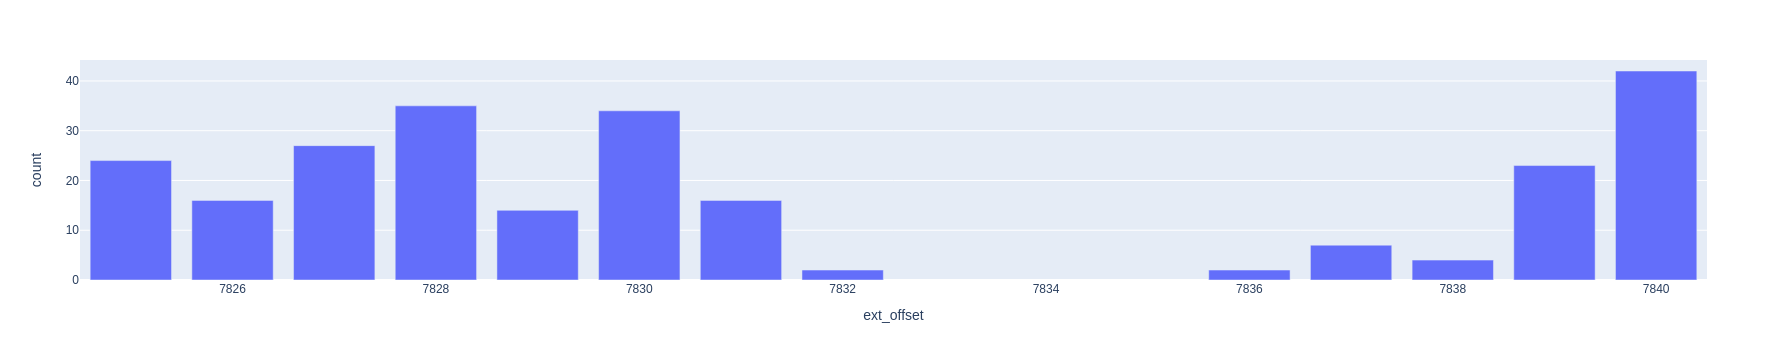

In [8]:
import plotly.express as px
import datetime
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import widgets
import plotly.express as p
fig = px.bar(gc_results_gg.extdf,x="ext_offset",y="count")
fig.update()
fig.show()

In [7]:
fig = px.bar(gboot.extdf,x="ext_offset",y="count")
fig.update()
fig.show()

NameError: name 'gboot' is not defined

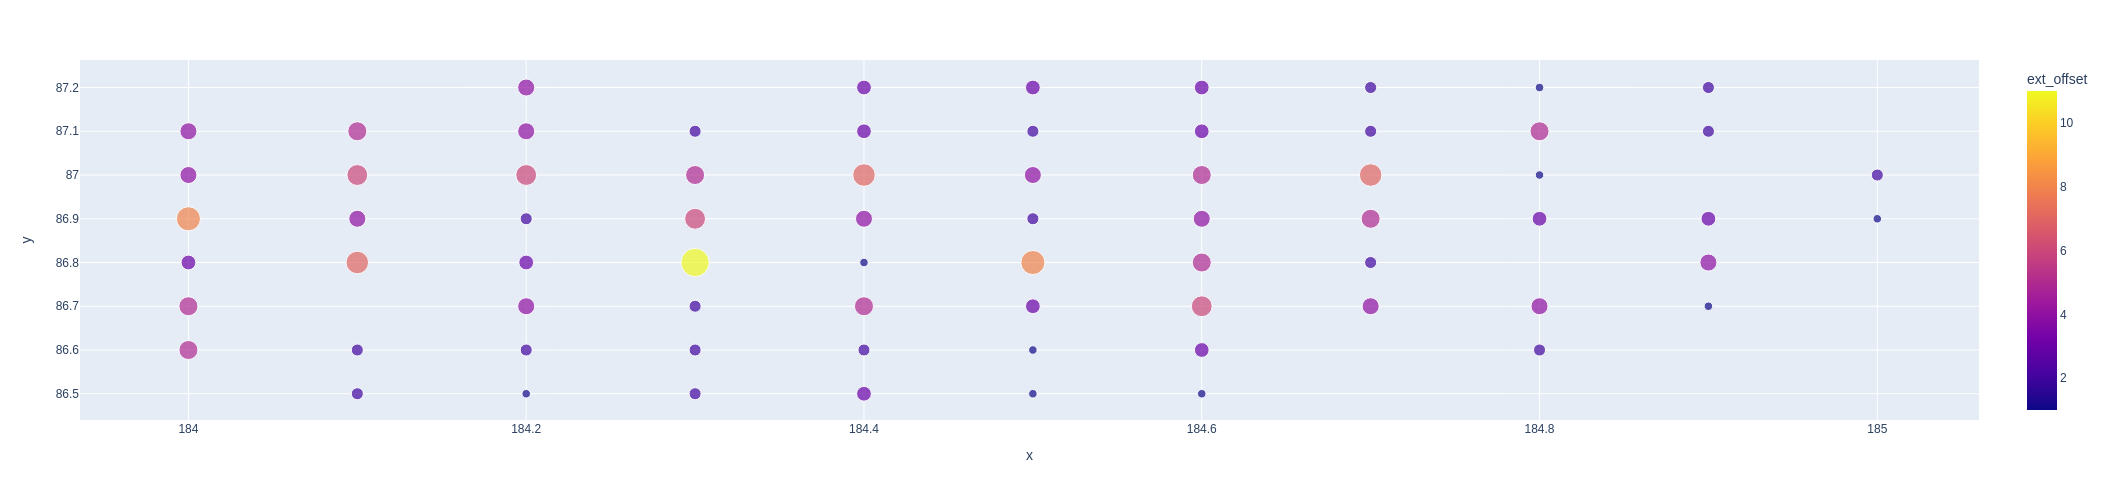

In [27]:
df = gc_results_gg.posdf
fig = px.scatter(df,x=df.x,y=df.y,size=df.ext_offset,color=df.ext_offset,height=500,width=500)
fig.show()

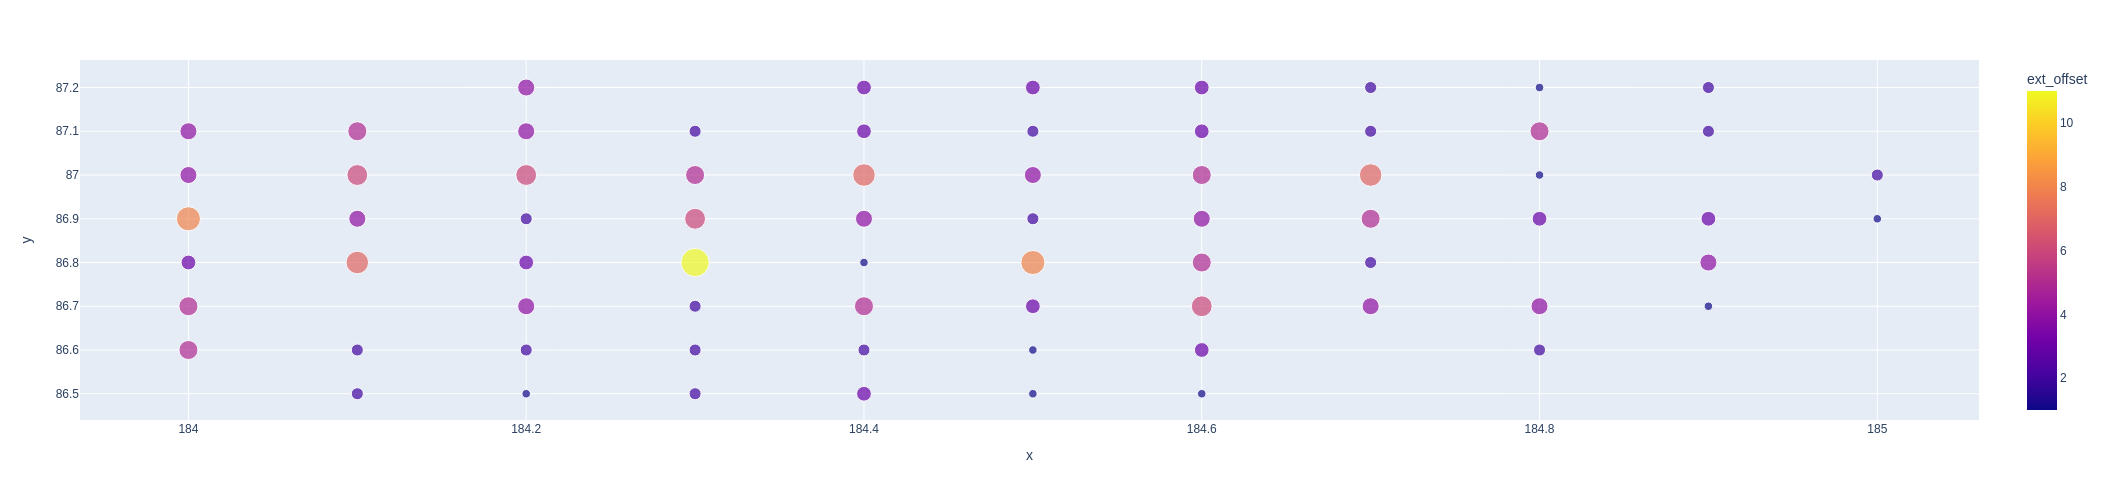

In [28]:
df = gc_results_gg.posdf
fig = px.scatter(df,x=df.x,y=df.y,size=df.ext_offset,color=df.ext_offset,height=500,width=500)
fig.show()

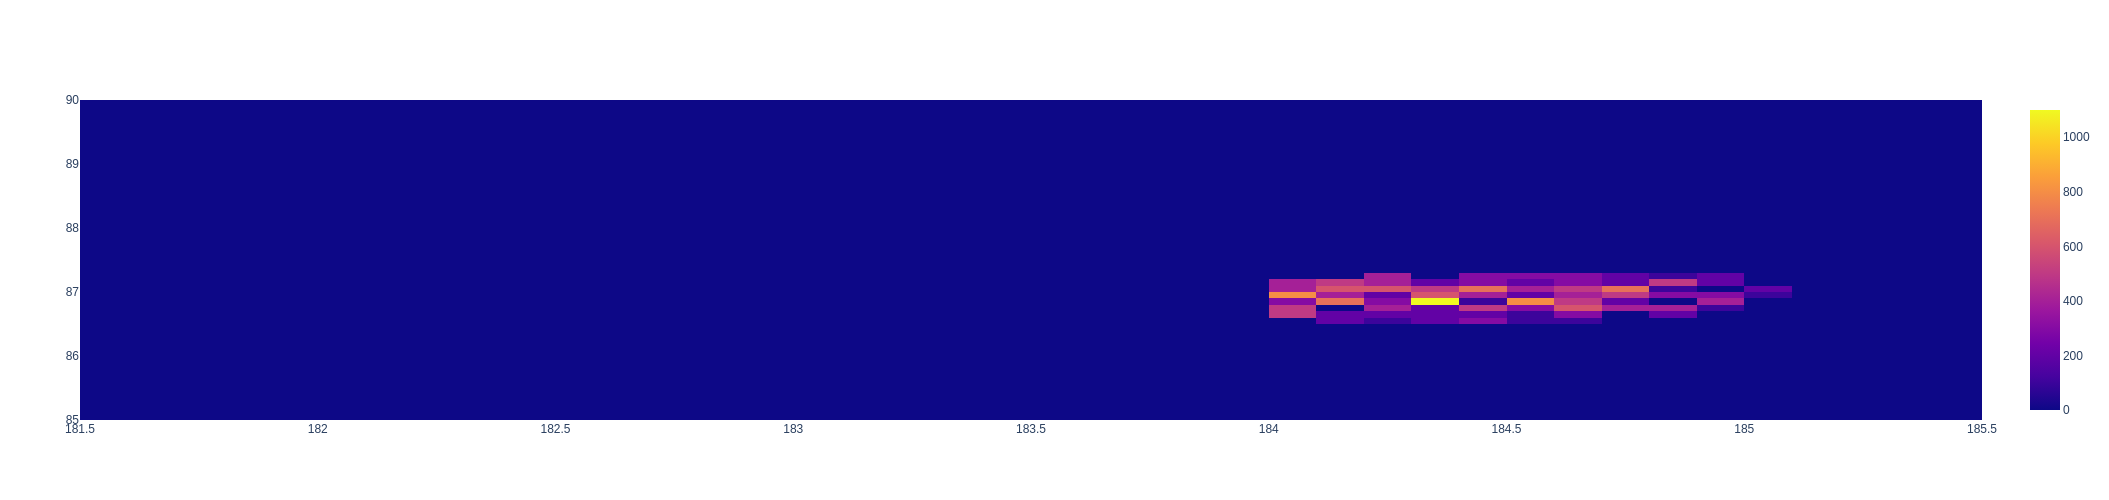

In [29]:
df = gc_results_gg.posdf
fig = go.Figure(go.Histogram2d(
    ids=df.ext_offset,
    x=df.x,
    xbins=dict(start=181.5, end=185.5, size=.1),
    y=df.y,
    ybins=dict(start=85, end=90, size=.1),
    histfunc="sum",
    histnorm="density",
))
fig.update_traces(z=df.ext_offset)
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
)
fig.show()

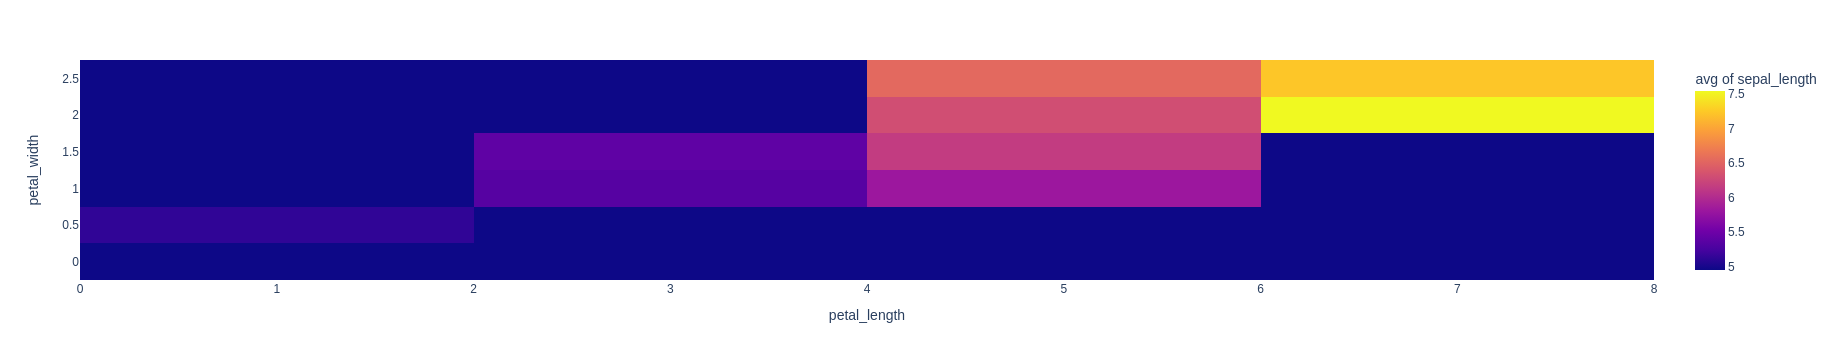

In [13]:
import plotly.express as px
df = px.data.iris()

fig = px.density_heatmap(df, x="petal_length", y="petal_width", z="sepal_length", histfunc="avg")
fig.show()